# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [2]:
cd ..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


### Load packages

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.ui import select_on_a_map
import cmocean

from intertidal.utils import (
    round_date_strings,
    intertidal_hillshade,
)
from intertidal.tide_modelling import pixel_tides_ensemble
from intertidal.io import (
    load_data,
    load_topobathy_mask,
    load_aclum_mask,
    prepare_for_export,
)
from intertidal.elevation import elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset

from dea_tools.dask import create_local_dask_cluster

## Setup


### Set analysis parameters

In [ ]:
# Intertidal Elevation variables
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'
filters=None # Exposure filters eg None, ['Dry', 'Neap_low']
filters_combined = None ## Must be a list of tuples containing one temporal and spatial filter each, eg None or [('Einter','Lowtide')]

##### Option 1: load study area from 32 km tile GridSpec

In [ ]:
# # Set study area (e.g. tile ID in form "x094y145")
# study_area = "x094y145"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [ ]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

<<<<<<< local


Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

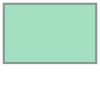

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

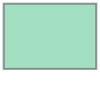

>>>>>>> remote


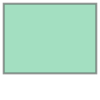

In [ ]:
# Set study area name for outputs
study_area = "testing"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Intertidal workflow

### Load data

In [ ]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds,_,_ = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

<<<<<<< local
/env/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32941 instead
  warnings.warn(
>>>>>>> remote
<<<<<<< local <modified: text/html, text/plain>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/32941/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/32941/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46561,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/32941/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:34565,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/40205/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:35867,


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39139,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:36231,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/34073/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:33185,


>>>>>>> remote <modified: text/html, text/plain>
<<<<<<< local <modified: >


<xarray.Dataset>
Dimensions:      (time: 430, y: 195, x: 239)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-07T02:06:41.398399 ... 2021-12...
  * y            (y) float64 -3.587e+06 -3.587e+06 ... -3.589e+06 -3.589e+06
  * x            (x) float64 -1.518e+06 -1.518e+06 ... -1.516e+06 -1.516e+06
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 195, 239), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


<xarray.Dataset> Size: 122MB
Dimensions:      (time: 506, y: 229, x: 263)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2020-01-01T00:20:38.303021 ... 202...
  * y            (y) float64 2kB -3.806e+06 -3.806e+06 ... -3.813e+06 -3.813e+06
  * x            (x) float64 2kB 5.873e+05 5.873e+05 ... 5.951e+05 5.951e+05
    spatial_ref  int32 4B 3577
Data variables:
    ndwi         (time, y, x) float32 122MB dask.array<chunksize=(1, 229, 263), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


>>>>>>> remote <modified: >
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
<<<<<<< local <modified: >


CPU times: user 9.02 s, sys: 1.56 s, total: 10.6 s
Wall time: 40.9 s


CPU times: user 8.31 s, sys: 647 ms, total: 8.96 s
Wall time: 1min 3s


>>>>>>> remote <modified: >
<<<<<<< local


<xarray.Dataset>
Dimensions:      (time: 430, y: 195, x: 239)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-07T02:06:41.398399 ... 2021-12...
  * y            (y) float64 -3.587e+06 -3.587e+06 ... -3.589e+06 -3.589e+06
  * x            (x) float64 -1.518e+06 -1.518e+06 ... -1.516e+06 -1.516e+06
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 0.2191 0.2114 0.2043 ... -0.4962 -0.5091
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

<xarray.Dataset> Size: 122MB
Dimensions:      (time: 506, y: 229, x: 263)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2020-01-01T00:20:38.303021 ... 202...
  * y            (y) float64 2kB -3.806e+06 -3.806e+06 ... -3.813e+06 -3.813e+06
  * x            (x) float64 2kB 5.873e+05 5.873e+05 ... 5.951e+05 5.951e+05
    spatial_ref  int32 4B 3577
Data variables:
    ndwi         (time, y, x) float32 122MB 0.5122 0.5175 ... -0.5667 -0.5872
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

>>>>>>> remote


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [10]:
# Load data from GA's AusBathyTopo 250m 2023 Grid
topobathy_mask = load_topobathy_mask(dc, geobox=satellite_ds.odc.geobox.compat)

In [41]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [ ]:
# Model elevation for each pixel
ds, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_mask,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

<<<<<<< local <modified: >
2024-02-20 05:50:10 INFO Modelling tide heights for each pixel
2024-05-12 23:34:22 INFO Processing: Modelling tide heights for each pixel
>>>>>>> remote <modified: >
<<<<<<< local


Running ensemble tide modelling
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


>>>>>>> remote
<<<<<<< local <modified: >


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


>>>>>>> remote <removed>
<<<<<<< local <modified: >
100%|██████████| 35/35 [00:29<00:00,  1.17it/s]
>>>>>>> remote <modified: >
<<<<<<< local


Returning low resolution tide array
Generating ensemble tide model from point inputs


Returning low resolution tide array
Generating ensemble tide model from point inputs
Interpolating model weights using 'idw' interpolation
                 weights
tide_model              
FES2014         0.390860
EOT20           0.388635
TPXO9-atlas-v5  0.387878
TPXO8-atlas-v1  0.384054
FES2012         0.382662
GOT4.10         0.365301
HAMTIDE11       0.123993
Reducing multiple models into single ensemble model using 'mean'
Reprojecting ensemble tides into original array


>>>>>>> remote
<<<<<<< local <modified: >
2024-02-20 05:50:34 INFO Masking nodata and adding tide heights to satellite data array
2024-02-20 05:50:34 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2024-02-20 05:50:34 INFO Applying valid data mask to constrain study area
2024-02-20 05:50:35 INFO Running per-pixel rolling median
2024-05-12 23:34:57 INFO Processing: Masking nodata and adding tide heights to satellite data array
2024-05-12 23:34:58 INFO Processing: Flattening satellite data array and filtering to intertidal candidate pixels
2024-05-12 23:34:58 INFO Processing: Applying valid data mask to constrain study area
2024-05-12 23:34:59 INFO Processing: Running per-pixel rolling median
>>>>>>> remote <modified: >
<<<<<<< local <modified: >


Reducing analysed pixels from 46605 to 3829 (8.22%)


Reducing analysed pixels from 60227 to 12280 (20.39%)


>>>>>>> remote <modified: >
<<<<<<< local


  0%|          | 0/105 [00:00<?, ?it/s]

2024-02-20 05:50:39 INFO Modelling intertidal elevation
2024-02-20 05:50:39 INFO Modelling intertidal uncertainty


  0%|          | 0/105 [00:00<?, ?it/s]

2024-05-12 23:35:16 INFO Processing: Modelling intertidal elevation
2024-05-12 23:35:16 INFO Processing: Modelling intertidal uncertainty
>>>>>>> remote
2023-12-19 01:38:05 INFO Modelling intertidal elevation


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


<<<<<<< local <modified: >
2024-02-20 05:50:40 INFO Unflattening data back to its original spatial dimensions
2024-02-20 05:50:40 INFO Cleaning inaccurate upper intertidal pixels
2024-02-20 05:50:40 INFO Successfully completed intertidal elevation modelling
2024-05-12 23:35:17 INFO Processing: Unflattening data back to its original spatial dimensions
2024-05-12 23:35:17 INFO Processing: Cleaning inaccurate upper intertidal pixels
2024-05-12 23:35:17 INFO Processing: Successfully completed intertidal elevation modelling
>>>>>>> remote <modified: >


### Intertidal extents


In [12]:
# Load and reclassify for intensive urban land use class only the ABARES ACLUM ds
reclassified_aclum = load_aclum_mask(dc, geobox=satellite_ds.odc.geobox.compat)

# Calculate intertidal extents
ds["extents"] = extents(
    dem=ds.elevation,
    freq=ds.qa_ndwi_freq,
    corr=ds.qa_ndwi_corr,
    reclassified_aclum=reclassified_aclum,
)

In [44]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
ds["extents"] = extents(
    freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr
)

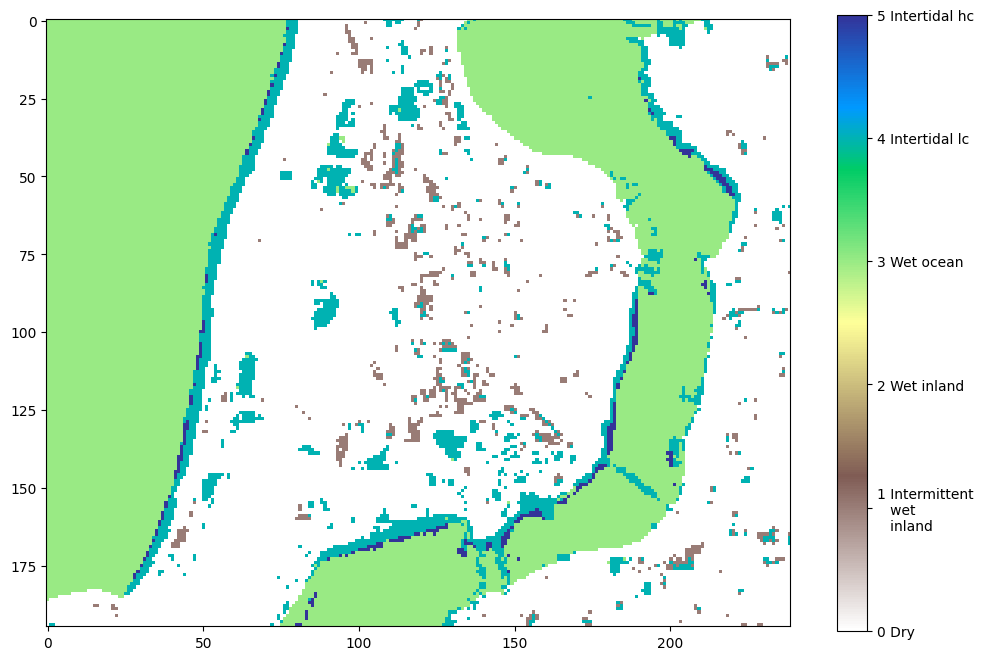

In [ ]:
# ## Plot with labels
# labels=['0 Dry',
#        '1 Intermittent\n   wet\n   inland',
#        '2 Wet inland',
#        '3 Wet ocean',
#        '4 Intertidal lc',
#        '5 Intertidal hc',
#        ]

# fig,ax=plt.subplots(figsize=(12,8))
# cax=ax.imshow(ds['extents'], cmap='terrain_r')
# cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
# cbar.ax.set_yticklabels(labels)
# plt.show()

### Intertidal exposure
Calculate exposure using the script function.
To calculate exposure for the full time period, leave `filters` commented out or set as ['unfiltered'].
See the function documentation for the full range of available filters and filter_combinations.
The code accepts lists of multiple filters and filter_combination tuples.

### Intertidal exposure
Calculate exposure using the script function.
To calculate exposure for the full time period, leave `filters` commented out or set as ['unfiltered'].
See the function documentation for the full range of available filters and filter_combinations.
The code accepts lists of multiple filters and filter_combination tuples.

In [25]:
exposure_filters, tide_cq_dict = exposure(
    dem=ds.elevation,
    start_date=start_date,
    end_date=end_date,
    modelled_freq = modelled_freq,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters=filters,
    filters_combined=filters_combined,
)

for x in list(exposure_filters.keys()):
    ds['exposure_'+str(x)]=exposure_filters[str(x)]

Running ensemble tide modelling
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:34<00:00,  1.00it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs
Interpolating model weights using 'idw' interpolation
                 weights
tide_model              
FES2014         0.390860
EOT20           0.388635
TPXO9-atlas-v5  0.387878
TPXO8-atlas-v1  0.384054
FES2012         0.382662
GOT4.10         0.365301
HAMTIDE11       0.123993
Reducing multiple models into single ensemble model using 'mean'
Reprojecting ensemble tides into original array
Running ensemble tide modelling
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:34<00:00,  1.00it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs
Interpolating model weights using 'idw' interpolation
                 weights
tide_model              
FES2014         0.390860
EOT20           0.388635
TPXO9-atlas-v5  0.387878
TPXO8-atlas-v1  0.384054
FES2012         0.382662
GOT4.10         0.365301
HAMTIDE11       0.123993
Reducing multiple models into single ensemble model using 'mean'
Returning low resolution ensemble tide array
-----
Calculating Lowtide timerange
-----
Calculating Neap_low timerange
-----
Calculating unfiltered exposure
-----
Calculating Lowtide exposure
-----
Calculating Neap_low exposure


### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights.

Warning: this code will only work if the exposure function has been run and produced 'unfiltered' exposure results.


In [ ]:
(
    ds["ta_lat"],
    ds["ta_hat"],
    ds["ta_lot"],
    ds["ta_hot"],
    ds["ta_spread"],
    ds["ta_offset_low"],
    ds["ta_offset_high"],
) = bias_offset(
    tide_m=tide_m, tide_cq=tide_cq_dict['unfiltered'], lot_hot=True, lat_hat=True
)

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

<<<<<<< local


<xarray.Dataset>
Dimensions:                (y: 12, x: 14)
Coordinates:
  * y                      (y) float64 -1.779e+06 -1.779e+06 ... -1.782e+06
  * x                      (x) float64 -9.646e+05 -9.644e+05 ... -9.608e+05
    spatial_ref            int32 3577
    band                   int64 1
Data variables: (12/14)
    elevation              (y, x) float64 nan nan nan nan ... nan nan nan nan
    elevation_uncertainty  (y, x) float64 nan nan nan nan ... nan nan nan nan
    extents                (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 3.0
    exposure_Hightide      (y, x) float64 nan nan nan nan ... nan nan nan nan
    exposure_wet           (y, x) float64 nan nan nan nan ... nan nan nan nan
    exposure_wet_Hightide  (y, x) float64 nan nan nan nan ... nan nan nan nan
    ...                     ...
    oa_hat                 (y, x) float32 nan nan nan nan ... nan nan nan 3.677
    oa_lot                 (y, x) float32 nan nan nan nan ... nan nan nan -3.154
    oa_hot                 (y, x) float32 nan nan nan nan ... nan nan nan 2.637
    oa_spread              (y, x) float32 nan nan nan nan ... nan nan nan 75.52
    oa_offset_lowtide      (y, x) float32 nan nan nan nan ... nan nan nan 10.92
    oa_offset_hightide     (y, x) float32 nan nan nan nan ... nan nan nan 13.56

<xarray.Dataset> Size: 6MB
Dimensions:                (y: 229, x: 263)
Coordinates:
  * y                      (y) float64 2kB -3.806e+06 -3.806e+06 ... -3.813e+06
  * x                      (x) float64 2kB 5.873e+05 5.873e+05 ... 5.951e+05
    spatial_ref            int32 4B 3577
    time                   datetime64[ns] 8B 2021-12-21T14:26:59.325771
Data variables: (12/16)
    elevation              (y, x) float64 482kB nan nan nan nan ... nan nan nan
    elevation_uncertainty  (y, x) float64 482kB nan nan nan nan ... nan nan nan
    qa_ndwi_corr           (y, x) float64 482kB nan nan nan nan ... nan nan nan
    qa_ndwi_freq           (y, x) float64 482kB 0.9943 0.9943 0.9971 ... 0.0 0.0
    extents                (y, x) float64 482kB 3.0 3.0 3.0 3.0 ... 0.0 0.0 0.0
    exposure_unfiltered    (y, x) float64 482kB nan nan nan nan ... nan nan nan
    ...                     ...
    ta_hat                 (y, x) float32 241kB 1.516 1.516 ... 1.516 1.516
    ta_lot                 (y, x) float32 241kB -1.255 -1.255 ... -1.283 -1.282
    ta_hot                 (y, x) float32 241kB 0.7612 0.7612 ... 0.7642 0.7642
    ta_spread              (y, x) float32 241kB 71.95 71.94 71.94 ... 72.71 72.7
    ta_offset_low          (y, x) float32 241kB 1.13 1.132 ... 0.5872 0.596
    ta_offset_high         (y, x) float32 241kB 26.92 26.92 26.92 ... 26.7 26.7

>>>>>>> remote


<Figure size 640x480 with 0 Axes>

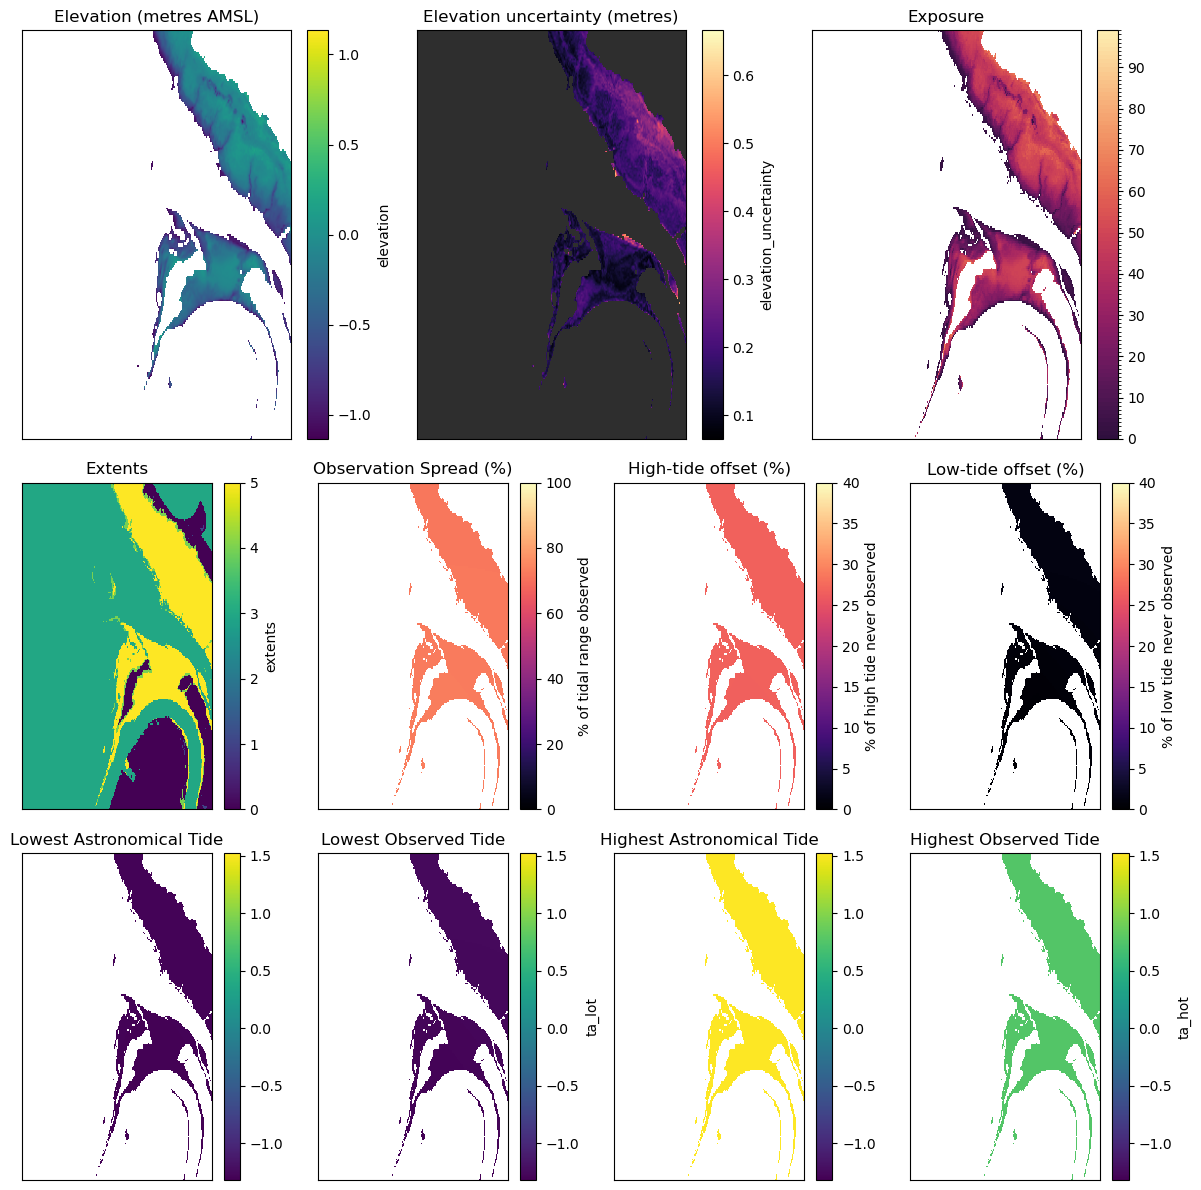

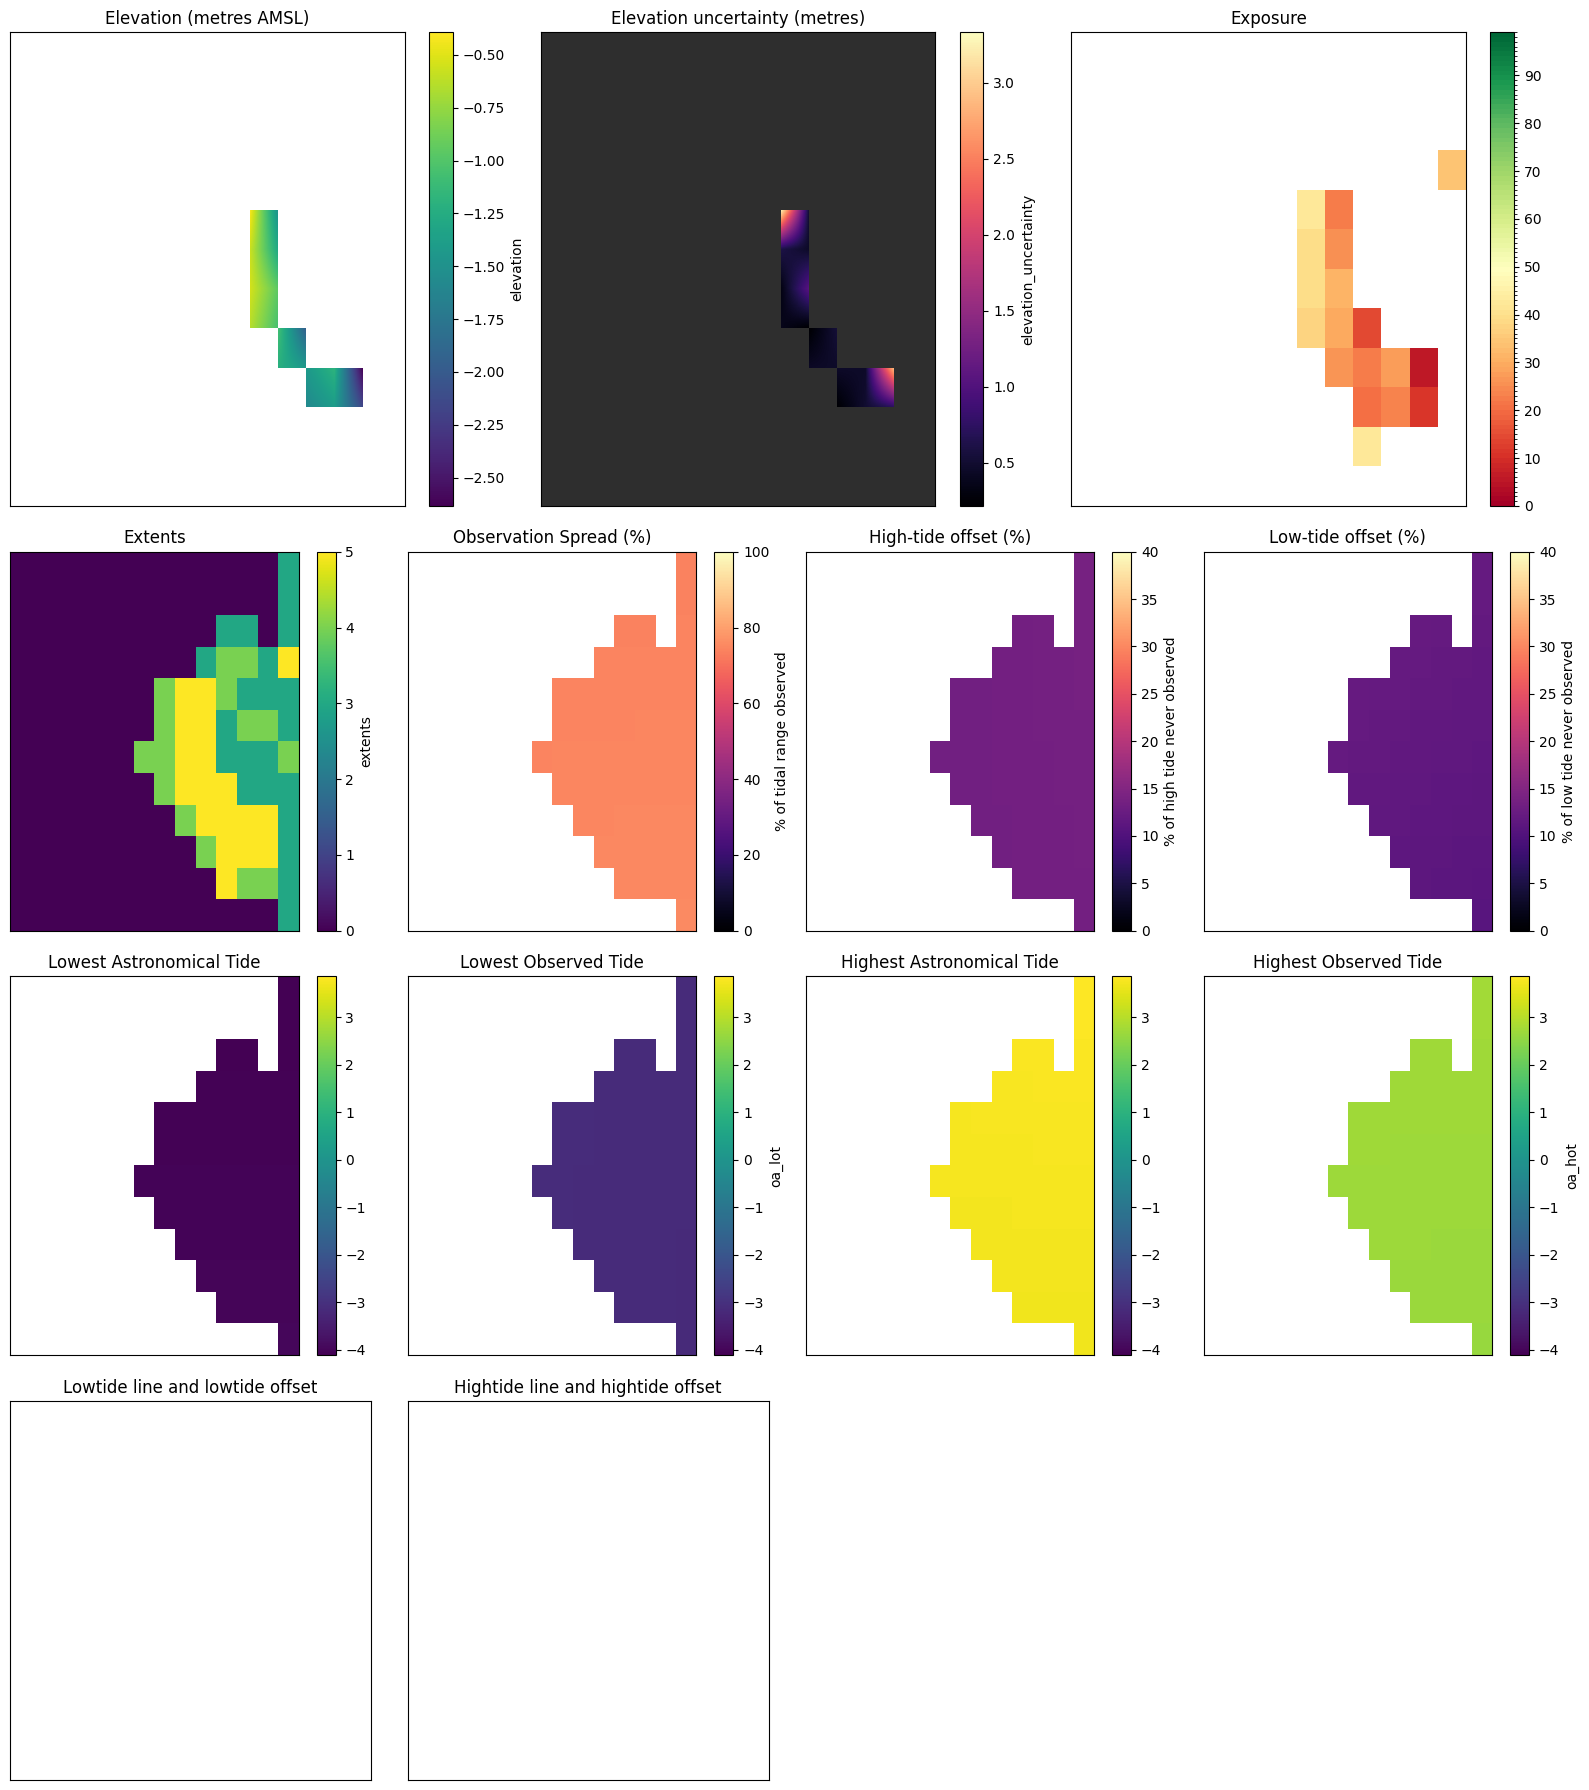

In [ ]:
plt.clf()

fig = plt.figure(figsize=(12, 12), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    """,
    height_ratios=[1, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
# intertidal_hillshade(ds["elevation"], ds["qa_ndwi_freq"], vert_exag=300).plot.imshow(
#     ax=ax_dict["A"],
#     interpolation="bilinear",
# )
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure_unfiltered"].plot.imshow(
    ax=ax_dict["C"],
    cmap=cmocean.cm.matter_r,
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot Extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Extents")

# Plot the observation spread
ds["ta_spread"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["ta_offset_high"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["F"],
ds["ta_offset_low"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},

# Plot the low-tide offset
ds["ta_offset_low"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["ta_lat"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["ta_lot"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["I"], vmin=ds["ta_lat"].min(), vmax=ds["ta_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["ta_hat"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["ta_hot"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# # Plot the high and low tidelines with respective offset
# ax_dict["L"].set_title("Lowtide line and lowtide offset")
# # lowtideline.plot(
# #     column="offset_lowtide",
# #     legend=True,
# #     vmin=0,
# #     vmax=40,
# #     cmap="magma",
# #     ax=ax_dict["L"],
# #     zorder=2,
# # )
# # tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
# ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
# ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# ax_dict["M"].set_title("Hightide line and hightide offset")
# # hightideline.plot(
# #     column="offset_hightide",
# #     legend=True,
# #     vmin=0,
# #     vmax=40,
# #     cmap="magma",
# #     ax=ax_dict["M"],
# #     zorder=2,
# # )
# # tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
# ax_dict["M"].set_yticks([])
# ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
# ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())



## Export layers

In [ ]:
# Create output folder if it doesn't exist
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes, then
# export to file
ds_prepared = prepare_for_export(ds, output_location=output_dir)

In [ ]:
# Export figure
fig.savefig(f"data/interim/{study_area}/{start_date}-{end_date}/outputs.png")

### Close Dask client

In [ ]:
client.close()